Metin veya konuşma biçiminde cümleler biçiminde yapılan girdileri anlamak için bilgisayar yazılımını kullanan bir yapay zeka dalıdır.

1. Text Preprocessing
2. Text Visualization
3. Sentiment Analysis
4. Feature Engineering
5. Sentiment Modeling

In [2]:

# !pip install nltk
# !pip install textblob
# !pip install wordcloud
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1. Text Preprocessing

In [3]:
df = pd.read_csv("datasets/amazon_reviews.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


Normalizing Case Folding(Küçük harfe çevrilmesi)

In [4]:
df["reviewText"] = df['reviewText'].str.lower()

Punctuations (Noktalama işaretlerinin kaldırılması)

In [5]:
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

Numbers (Sayıların kaldırılması)

In [6]:
df['reviewText'] = df['reviewText'].str.replace('\d', '')

Stopwords (Çok sık kullanılan kelimelerin kaldırılması)

In [7]:
import nltk
# nltk.download('stopwords')
sw = stopwords.words('english')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))


Rarewords(Çok az kullanılan kelimelerin kaldırılması)

In [8]:
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()

drops = temp_df[temp_df <= 1]

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))


Tokenization (Kelime ayrıştırma)

In [9]:
#nltk.download("punkt")

df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

Lemmatization(Kelime köklerinin bulunması)

In [10]:
#nltk.download('wordnet')


In [11]:
import nltk
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# 2. Text Visualization

Terim Frekanslarının Hesaplanması

In [12]:
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)


,words,tf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
39,gb,1756.00
98,great,1445.00
...,...,...
2721,sizethe,2.00
2719,everybody,2.00
2717,lived,2.00
3687,chkdsk,2.00


Barplot

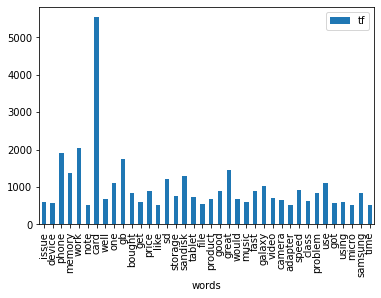

In [13]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

Wordcloud

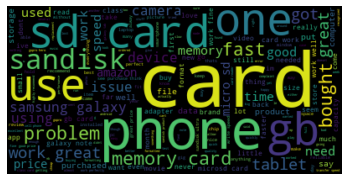

In [14]:
text = " ".join(i for i in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

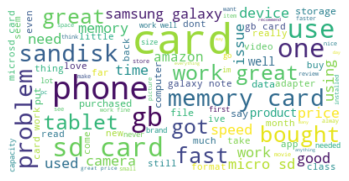

In [15]:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

Şablonlara Göre Wordcloud

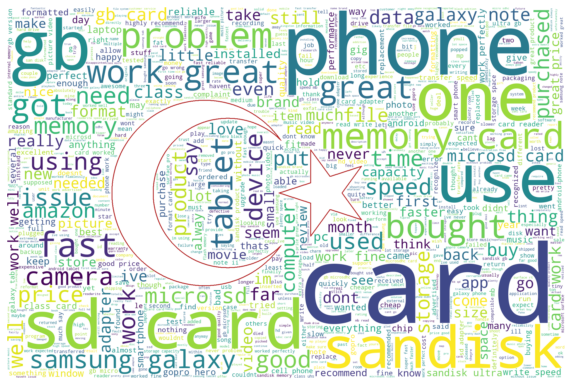

In [16]:
tr_mask = np.array(Image.open("tr.png"))

wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Sentiment Analysis


In [17]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [18]:
#nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome.")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [19]:
sia.polarity_scores("I liked this music but it is not good as the other one.")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [20]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'comp...
3    {'neg': 0.0, 'neu': 0.798, 'pos': 0.202, 'comp...
4    {'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.108, 'neu': 0.598, 'pos': 0.295, 'co...
7    {'neg': 0.077, 'neu': 0.65, 'pos': 0.272, 'com...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.457, 'pos': 0.543, 'comp...
Name: reviewText, dtype: object

In [21]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.00
1   0.00
2   0.40
3   0.65
4   0.86
5   0.00
6   0.87
7   0.82
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [22]:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])

# 4. Feature Engineering


In [23]:
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [24]:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [25]:
df["sentiment_label"].value_counts()

pos    3944
neg     971
Name: sentiment_label, dtype: int64

In [26]:
df.groupby("sentiment_label").agg({"overall": "mean"})

,overall
sentiment_label,
neg,4.09
pos,4.71


In [27]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [28]:
y = df["sentiment_label"]
X = df["reviewText"]


Count Vectors

 Count Vectors: frekans temsiller

 TF-IDF Vectors: normalize edilmiş frekans temsiller
 
 Word Embeddings (Word2Vec, GloVe, BERT vs)


 words
 kelimelerin nümerik temsilleri

 characters
 karakterlerin numerik temsilleri


In [29]:
a = """Bu örneği anlaşılabilmesi için daha uzun bir metin üzerinden göstereceğim.
N-gram'lar birlikte kullanılan kelimelerin kombinasyolarını gösterir ve feature üretmek için kullanılır"""

TextBlob(a).ngrams(3)

[WordList(['Bu', 'örneği', 'anlaşılabilmesi']),
 WordList(['örneği', 'anlaşılabilmesi', 'için']),
 WordList(['anlaşılabilmesi', 'için', 'daha']),
 WordList(['için', 'daha', 'uzun']),
 WordList(['daha', 'uzun', 'bir']),
 WordList(['uzun', 'bir', 'metin']),
 WordList(['bir', 'metin', 'üzerinden']),
 WordList(['metin', 'üzerinden', 'göstereceğim']),
 WordList(['üzerinden', 'göstereceğim', "N-gram'lar"]),
 WordList(['göstereceğim', "N-gram'lar", 'birlikte']),
 WordList(["N-gram'lar", 'birlikte', 'kullanılan']),
 WordList(['birlikte', 'kullanılan', 'kelimelerin']),
 WordList(['kullanılan', 'kelimelerin', 'kombinasyolarını']),
 WordList(['kelimelerin', 'kombinasyolarını', 'gösterir']),
 WordList(['kombinasyolarını', 'gösterir', 've']),
 WordList(['gösterir', 've', 'feature']),
 WordList(['ve', 'feature', 'üretmek']),
 WordList(['feature', 'üretmek', 'için']),
 WordList(['üretmek', 'için', 'kullanılır'])]

Count Vectors

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']


In [31]:
# word frekans
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
X_c.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [32]:
# n-gram frekans
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names()
X_n.toarray()


array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]], dtype=int64)

In [33]:
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names()[10:15]
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)


tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

# 5. Sentiment Modeling

Logistic Regression

In [35]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()


new_review = pd.Series("this product is great")
new_review = pd.Series("look at that shit very bad")
new_review = pd.Series("it was good but I am sure that it fits me")

new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)


array([1])

In [36]:
random_review = pd.Series(df["reviewText"].sample(1).values)

new_review = TfidfVectorizer().fit(X).transform(random_review)

log_model.predict(new_review)

array([1])

Random Forests

In [37]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

0.8447609359104782

In [38]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

0.8280773143438453

In [39]:
# TF-IDF N-GRAM
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean()


0.7871820956256357

# Hiperparametre Optimizasyonu


In [40]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1).fit(X_count, y)

rf_best_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [41]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)


cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

0.8408952187182095